# ASSIGNMENT 2A

Name: Ananya Pandey

Tutorial: 015

# 1. Data preparation and exploration

## 1.1 Creating Spark Session

##### 1. Create a SparkConf object for using as many local cores as possible, for a proper application name, and for changing the max partition byte configuration to enable a minimum of 2 partitions when reading each file in Spark SQL

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment 2A"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set('spark.sql.files.maxPartitionBytes','35000000')

##### 2. Then create a SparkSession using the SparkConf object.

In [2]:
# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

spark = SparkSession.builder.config(conf = spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, IndexToString, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col, rand
import numpy as np 
import matplotlib.pyplot as plt  
import pandas as pd

## 1.2 Loading the data
##### 1. Load each activity data into a Spark dataframe and cache the data. Then print out the row count of each dataframe.

In [4]:
from pyspark.sql.types import StructType, IntegerType, StructField, StringType, DoubleType
memory_schema = StructType([
    StructField("ts", IntegerType()),
    StructField("PID", IntegerType()),
    StructField("MINFLT", StringType()),
    StructField("MAJFLT", StringType()),
    StructField("VSTEXT", StringType()),
    StructField("VSIZE", DoubleType()),
    StructField("RSIZE", StringType()),
    StructField("VGROW", StringType()),
    StructField("RGROW", StringType()),
    StructField("MEM", DoubleType()),
    StructField("CMD", StringType()),
    StructField("attack", IntegerType()),
    StructField("type", StringType())
])


In [5]:
#Load all the units csv files in a units_df dataframe
a = ["linux_memory_1.csv", "linux_memory_2.csv"]
memory_df = spark.read.csv(a, header=True, schema=memory_schema).cache()

In [6]:
process_schema = StructType([
    StructField("ts", IntegerType()),
    StructField("PID", IntegerType()),
    StructField("TRUN", IntegerType()),
    StructField("TSLPI", IntegerType()),
    StructField("TSLPU", IntegerType()),
    StructField("POLI", StringType()),
    StructField("NICE", IntegerType()),
    StructField("PRI", IntegerType()),
    StructField("RTPR", IntegerType()),
    StructField("CPUNR", IntegerType()),
    StructField("Status", StringType()),
    StructField("EXC", IntegerType()),
    StructField("State", StringType()),
    StructField("CPU", IntegerType()),
    StructField("CMD", StringType()),
    StructField("attack", IntegerType()),
    StructField("type", StringType())
])

In [7]:
#Load all the units csv files in a units_df dataframe
b = ["linux_process_1.csv", "linux_process_2.csv"]
process_df = spark.read.csv(b, header=True, schema=process_schema).cache()
#process_df = spark.read.csv(b, header=True, inferSchema=True).cache()

In [8]:
memory_df.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [9]:
process_df.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: integer (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [10]:
print("Row count of memory activity:",memory_df.count())

Row count of memory activity: 2000000


In [11]:
print("Row count of process activity:",process_df.count())

Row count of process activity: 1927968


##### 2. For each column in each dataframe above,
##### ○ Check the null data (if any) and print out the corresponding count in each column
##### ○ Are these columns 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW', 'RGROW' in memory data following the datatype from the metadata file? If not, please transform them into the proper formats

In [12]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

In [13]:
from pyspark.sql.functions import isnan, when, count, col
memory_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in memory_df.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [14]:
from pyspark.sql.functions import isnan, when, count, col
process_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in process_df.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+------+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|   CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+------+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|512374|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+------+---+------+----+



In [15]:
pandas_df = memory_df.select("*").toPandas()

In [16]:
pandas_df.MINFLT = pandas_df.MINFLT.str.replace(' ', '')
pandas_df.MAJFLT = pandas_df.MAJFLT.str.replace(' ', '')
pandas_df.VSTEXT = pandas_df.VSTEXT.str.replace(' ', '')
pandas_df.RSIZE = pandas_df.RSIZE.str.replace(' ', '')
pandas_df.VGROW = pandas_df.VGROW.str.replace(' ', '')
pandas_df.RGROW = pandas_df.RGROW.str.replace(' ', '')

##### Reference:
Njuguna, J. (2020). Convert the string 2.90K to 2900 or 5.2M to 5200000 in pandas dataframe. Retrieved 3 October 2020, from https://stackoverflow.com/questions/39684548/convert-the-string-2-90k-to-2900-or-5-2m-to-5200000-in-pandas-dataframe

In [17]:
pandas_df.MINFLT = (pandas_df.MINFLT.replace(r'[KMG]+$', '', regex=True).astype(float) * pandas_df.MINFLT.str.extract(r'[\d\.]+([KMG]+)', expand=False).fillna(1).replace(['K','M', 'G'], [10**3, 10**6, 10**9]).astype(int))
pandas_df.MAJFLT = (pandas_df.MAJFLT.replace(r'[KMG]+$', '', regex=True).astype(float) * pandas_df.MAJFLT.str.extract(r'[\d\.]+([KMG]+)', expand=False).fillna(1).replace(['K','M', 'G'], [10**3, 10**6, 10**9]).astype(int))
pandas_df.VSTEXT = (pandas_df.VSTEXT.replace(r'[KMG]+$', '', regex=True).astype(float) * pandas_df.VSTEXT.str.extract(r'[\d\.]+([KMG]+)', expand=False).fillna(1).replace(['K','M', 'G'], [10**3, 10**6, 10**9]).astype(int))
pandas_df.RSIZE = (pandas_df.RSIZE.replace(r'[KMG]+$', '', regex=True).astype(float) * pandas_df.RSIZE.str.extract(r'[\d\.]+([KMG]+)', expand=False).fillna(1).replace(['K','M', 'G'], [10**3, 10**6, 10**9]).astype(int))
pandas_df.VGROW = (pandas_df.VGROW.replace(r'[KMG]+$', '', regex=True).astype(float) * pandas_df.VGROW.str.extract(r'[\d\.]+([KMG]+)', expand=False).fillna(1).replace(['K','M', 'G'], [10**3, 10**6, 10**9]).astype(int))
pandas_df.RGROW = (pandas_df.RGROW.replace(r'[KMG]+$', '', regex=True).astype(float) * pandas_df.RGROW.str.extract(r'[\d\.]+([KMG]+)', expand=False).fillna(1).replace(['K','M', 'G'], [10**3, 10**6, 10**9]).astype(int))

In [18]:
memory_df = spark.createDataFrame(pandas_df)

In [19]:
#the cleaned memory data is put into another variable
memory_clean = memory_df

In [20]:
memory_clean.printSchema()

root
 |-- ts: long (nullable = true)
 |-- PID: long (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: long (nullable = true)
 |-- type: string (nullable = true)



## 1.3 Exploring the data
##### 1. Show the count of attack and non-attack in each activity based on the column “attack”, then show the count of each kind of attack in process activity based on the column “type”.
##### ○ Do you see any class imbalance? Examine and describe what you observe

In [21]:
#instances target variable has
memory_clean.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|     0|1794377|
|     1| 205623|
+------+-------+



In [22]:
process_df.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 291364|
|     0|1636604|
+------+-------+



##### DESCRIPTION:
Ideally, the data points available for the classes should be around 50% if there are two classes. Here, class imbalance can be seen i.e. the number of data points available for different classes is different. 
It can be observed that the data points for non-attack i.e. attack=0 are way more than the data points for attack where attack=1 .

In [23]:
memory_clean.groupBy('type').count().show()

+---------+-------+
|     type|  count|
+---------+-------+
| password|  26016|
|     ddos|  45689|
|   normal|1794377|
|     mitm|    112|
|injection|  58523|
|      dos|  75283|
+---------+-------+



In [24]:
process_df.groupBy('type').count().show()

+---------+-------+
|     type|  count|
+---------+-------+
|      xss|  17759|
| password|  51409|
| scanning|  38449|
|     ddos|  71603|
|   normal|1636604|
|     mitm|    112|
|injection|  41311|
|      dos|  70721|
+---------+-------+



##### DESCRIPTION:
As from the above two tables, it can be seen that the "normal" type represents non-attack i.e. attack=0 and the rest of the columns show the type of attack for attack=1. 
This can be said because the count of "normal" type of attack is exact same as the count of non-attacks for the two use cases i.e. memory and process.

##### 2. For each numeric feature in each activity, show the basic statistics (including count, mean, stddev, min, max); for each non-numeric feature in each activity, display the top-10 values and the corresponding counts.
##### ○ No need to show the labels at “attack” or “type” column

In [25]:
#Summary Statistics
num = ['ts', 'PID', 'MINFLT', 'MAJFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'VGROW', 'RGROW', 'MEM']
df = memory_clean[num]
df.describe().show()

+-------+------------------+-----------------+-----------------+--------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+
|summary|                ts|              PID|           MINFLT|              MAJFLT|            VSTEXT|            VSIZE|             RSIZE|            VGROW|             RGROW|                 MEM|
+-------+------------------+-----------------+-----------------+--------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+
|  count|           2000000|          2000000|          2000000|             2000000|           2000000|          2000000|           2000000|          2000000|           2000000|             2000000|
|   mean|1.55624581707609E9|      4999.360446|       983.344344|   987846.5873272612|46453.274152098085| 4496.41996644669|23722.888664202434|984.4668735599992|483.17466255000016|0.003385165000006418|


In [26]:
col=['CMD']
df = memory_clean[col]
df.groupBy('CMD').count().show(10)

+--------------+-----+
|           CMD|count|
+--------------+-----+
|        <kmod>|    6|
|         jfsIO|13619|
|kworker/4:2-mm|  147|
|     <dumpcap>|   18|
|        <fsck>|  192|
|    <basename>|   45|
|<kworker/dyin>|  603|
|<rsyslog-rota>|    3|
|ibus-extension| 5788|
|       <iconv>|    1|
+--------------+-----+
only showing top 10 rows



In [28]:
num_cols = ['ts','PID','TRUN','TSLPI','TSLPU','NICE','PRI','RTPR','CPUNR','EXC','CPU']#numerical columns of process activity

In [29]:
num_df = process_df[num_cols]
num_df.describe().show()

+-------+--------------------+-----------------+------------------+-----------------+--------------------+-----------------+------------------+-------+------------------+--------------------+--------------------+
|summary|                  ts|              PID|              TRUN|            TSLPI|               TSLPU|             NICE|               PRI|   RTPR|             CPUNR|                 EXC|                 CPU|
+-------+--------------------+-----------------+------------------+-----------------+--------------------+-----------------+------------------+-------+------------------+--------------------+--------------------+
|  count|             1927968|          1927968|           1927968|          1927968|             1927968|          1927968|           1927968|1927968|           1927968|             1927968|             1415594|
|   mean|1.5563198311840394E9|5068.709770597852|0.0632287465352122|3.508334163222626|3.610018423542299...|4.634469555511295|111.26826741937626|    0

In [30]:
from pyspark.sql.functions import desc

In [31]:
non_num_cols = ['POLI','Status','State','CMD'] # categorical variables of process
non_num_df = process_df[non_num_cols]
non_num_df.groupBy('POLI').count().sort(desc("count")).show(10)

+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+



In [32]:
non_num_df.groupBy('Status').count().sort(desc("count")).show(10)

+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+



In [33]:
non_num_df.groupBy('State').count().sort(desc("count")).show(10)

+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+



In [34]:
non_num_df.groupBy('CMD').count().sort(desc("count")).show(10)

+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



##### 3. For each activity, present two plots worthy of presenting to the StopHacking company, describe your plots and discuss the findings from the plots

In [35]:
#Due to latency issues, a very small sample of the data is taken
#taking a sample of the data as the data is very large to be plotted
newSample = memory_clean.sample(False, 0.002) #sample of memory_df

In [36]:
sample_df = newSample.select("*").toPandas()

In [37]:
processSample = process_df.sample(False, 0.002)#sample of process_df

In [38]:
process_sample_df = processSample.select("*").toPandas()

#### MEMORY ACTIVITY

Text(0.5, 1.0, 'Correlation Matrix')

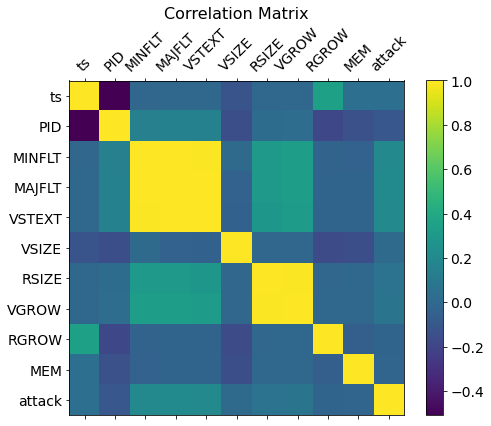

In [39]:
#memory_df
f = plt.figure(figsize=(8, 6))
corr=sample_df.corr()
plt.matshow(corr, fignum=f.number)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=45)
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

##### DESCRIPTION:
The correlation matrix shown above tells about the correlation between variables by plotting the correlation coefficients.
On the right hand side you have the scale which is colored from purple (negative correlation) to yellow (positive correlation). The color follows a gradient according to the strength of the correlation.
A high correlation of attack can be seen with MINFLT, MAJFLT, VSTEXT, RSIZE as they are the lightest in color as compared to the other variables' correlation with attack.



#### References:
* Pearson's Correlation Coefficient - Statistics Solutions. (2020). Retrieved 3 October 2020, from https://www.statisticssolutions.com/pearsons-correlation-coefficient/

* How do I interpret the output of corrplot?. (2020). Retrieved 3 October 2020, from https://stackoverflow.com/questions/24298793/how-do-i-interpret-the-output-of-corrplot

Text(0.5, 0, 'attack')

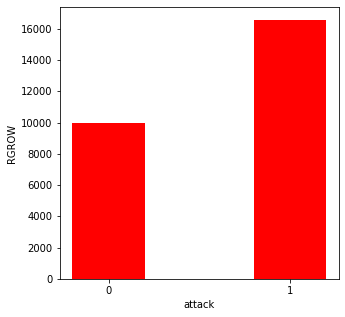

In [40]:
fig = plt.figure(figsize = (5, 5)) 
  
# creating the bar plot 
plt.bar(sample_df['attack'], sample_df['RGROW'], color ='red', width = 0.4)
plt.xticks(np.arange(0, 2, 1))
plt.ylabel('RGROW')
plt.xlabel('attack')

#### DESCRIPTION:
The bar graph shown above tells about the relation of attack with respect to RGROW column. There is a high imbalance in the values showing attack and non-attack i.e. 1 and 0. When we see such difference in values, it can't be clearly said that this particular column can help in predicting whether it is an attack or a non-attack condition more effectively.
Thus from the above graph we can infer that the RGROW column has one of the lowest correlation with the attack column in comparison to others.

#### PROCESS ACTIVITY

In [41]:
process_corr = process_sample_df.corr()
process_corr.style.background_gradient(cmap='coolwarm')

/home/student/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/home/student/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU,attack
ts,1.000000,0.043482,-0.029529,0.002866,nan,-0.049121,0.096663,nan,0.185519,-0.012912,-0.008898,0.026634
PID,0.043482,1.000000,-0.070125,-0.181866,nan,-0.141549,-0.158533,nan,0.102534,-0.002115,-0.016316,-0.046521
TRUN,-0.029529,-0.070125,1.000000,0.006548,nan,0.231483,-0.033034,nan,-0.047186,-0.007755,0.324741,-0.013084
TSLPI,0.002866,-0.181866,0.006548,1.000000,nan,-0.209387,0.172640,nan,0.075968,-0.015538,0.037234,0.060208
TSLPU,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
NICE,-0.049121,-0.141549,0.231483,-0.209387,nan,1.000000,-0.247328,nan,-0.099217,-0.016932,0.001244,-0.070777
PRI,0.096663,-0.158533,-0.033034,0.172640,nan,-0.247328,1.000000,nan,0.279098,-0.143898,0.011278,-0.007940
RTPR,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CPUNR,0.185519,0.102534,-0.047186,0.075968,nan,-0.099217,0.279098,nan,1.000000,-0.038457,-0.045114,0.004728
EXC,-0.012912,-0.002115,-0.007755,-0.015538,nan,-0.016932,-0.143898,nan,-0.038457,1.000000,-0.001811,-0.011261


#### DESCRIPTION:
The above correlation plot shows the value of the correlation coefficients with all the other columns. The correlation coeffiient of a column with itself is always said to be 1. 

It can be seen that TSLPU and RTPR have NaN values as they have no correlation with any other column.
Columns like TSLPI, EXC and CPUNR have high correlation coefficients in comparison to the othe columns.

Text(0.5, 0, 'attack')

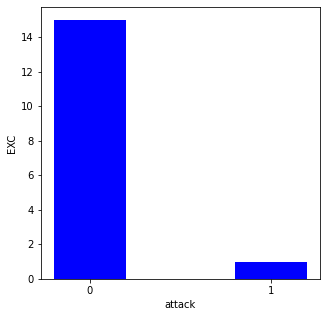

In [44]:
fig = plt.figure(figsize = (5, 5)) 
  
# creating the bar plot 
plt.bar(process_sample_df['attack'], process_sample_df['EXC'], color ='blue', width = 0.4)
plt.xticks(np.arange(0, 2, 1))
plt.ylabel('EXC')
plt.xlabel('attack')

#### DESCRIPTION:
The bar graph shown above tells about the relation of attack with respect to EXC column. There is a high imbalance in the values showing attack and non-attack i.e. 1 and 0. When we see such difference in values, it can't clearly say that this particular value can help in predicting whether it is an attack or a non-attack condition more effectively.

# 2. Feature extraction and ML training
## 2.1 Preparing the training data and testing data

##### 1. Randomly split the dataset into 80% training data and 20% testing data for each use case

In [45]:
memory_train, memory_test = memory_clean.randomSplit([0.8, 0.2], seed=2020)
process_train, process_test = process_df.randomSplit([0.8, 0.2], seed=2020)

##### 2. With the class imbalance observed from 1.3.1, for the binary classification use case 1 & 2, prepare rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using 20% attack events data from the training data from 2.1.1. Cache the rebalanced training data, and display the count of each event's data.

In [46]:
attack_train = memory_train.filter(memory_train.attack=='1')
non_attack_train = memory_train.filter(memory_train.attack=='0')

###### Please Note: Due to latency issues, 5% attack data is taken but the condition of 1:2 ratio stays in place.

In [47]:
rebalanced_attack = attack_train.sample(False, 0.05)

In [48]:
n=rebalanced_attack.count() #count of the attack data in the train sample of attack training data of memory.

In [49]:
#twice the count of attack rows are taken for the non-attack data
rebalanced_non_attack = non_attack_train.orderBy(rand()).limit(2*n)

In [50]:
rebalanced_memory = rebalanced_attack.union(rebalanced_non_attack)
rebalanced_memory.cache()

DataFrame[ts: bigint, PID: bigint, MINFLT: double, MAJFLT: double, VSTEXT: double, VSIZE: double, RSIZE: double, VGROW: double, RGROW: double, MEM: double, CMD: string, attack: bigint, type: string]

In [51]:
process_attack_train = process_train.filter(process_train.attack=='1')
process_non_attack_train = process_train.filter(process_train.attack=='0')

###### Please Note: Due to latency issues, 5% attack data is taken but the condition of 1:2 ratio stays in place.

In [52]:
rebalanced_process_attack = process_attack_train.sample(False, 0.05)

In [53]:
n1=rebalanced_process_attack.count()

In [54]:
rebalanced_process_non_attack = process_non_attack_train.orderBy(rand()).limit(2*n1)

In [55]:
rebalanced_process = rebalanced_process_attack.union(rebalanced_process_non_attack)
rebalanced_process.cache()

DataFrame[ts: int, PID: int, TRUN: int, TSLPI: int, TSLPU: int, POLI: string, NICE: int, PRI: int, RTPR: int, CPUNR: int, Status: string, EXC: int, State: string, CPU: int, CMD: string, attack: int, type: string]

In [56]:
print("Count of rebalanced training data for memory activity:",rebalanced_memory.count())

Count of rebalanced training data for memory activity: 24561


In [57]:
print("Count of rebalanced training data for process activity:",rebalanced_process.count())

Count of rebalanced training data for process activity: 35217


## 2.2 Preparing features, labels and models
##### 1. Based on data exploration from 1.3.3, which features would you select? Discuss the reason for selecting them and how you plan to further transform them.

For the memory activity, 'ts', 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW' and 'MEM' have been selected keeping in mind the correlation of these columns with attack. These are the columns with most correlation with the attack column that is the reason they have been chosen.
As all these columns are numeric, so VectorAssembler and StandardScaler are chosen. VectorAssembler is chosen in order to merge multiple columns into a vector column and the StandardScaler transforms the numeric data such that its distribution will have a mean value 0 and standard deviation of 1.

For the process activity, 'ts', 'TSLPI', 'CPUNR', 'PRI','CPU', 'POLI', 'Status', 'State' and 'CMD' have been selected based on how well they are related to the attack column. Out of these, 'ts', 'TSLPI','PRI', 'CPUNR', 'CPU' are the numeric columns and 'POLI', 'Status', 'State' and 'CMD' are the non-numeric ones. The non-numeric columns are first passed through a StringIndexer and then one-hot encoding is performed on them. The output of the one-hot encoder and the numeric columns are now combined and then put in a VectorAssembler for further transformation.

##### 2. Create Transformers / Estimators for transforming / assembling the features you selected above in 2.2.1.

In [58]:
memory_num = ['ts','MINFLT','MAJFLT','VSTEXT','RSIZE','VGROW', 'MEM']
memory_df_num = memory_df[memory_num]

In [59]:
#Define the vector Assembler Here
assembler = VectorAssembler(inputCols=memory_num, outputCol='features')

In [60]:
#Define the Standard Scaler here
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

In [61]:
process_num_cols = ['ts','PRI','TSLPI','CPUNR','CPU']
process_df_num = process_df[process_num_cols]

non_num_cols = ['POLI','Status','State','CMD']
process_non_num_df = process_df[non_num_cols]

In [62]:
#PROCESS ACTIVITY
# STRING INDEXER

#Define the input columns
inputCols_process=[x for x in process_non_num_df.columns]
#Define the output columns 
outputCols_process=[f'{x}_index' for x in process_non_num_df.columns]

# Initialize StringIndexer (use inputCols and outputCols)
stage_1_process = StringIndexer(inputCols=inputCols_process, outputCols=outputCols_process)

In [63]:
#OHE

#WRITE THE CODE WHERE NECESSARY
#the outputcols of previous step act as input cols for this step
inputCols_OHE_process = [x for x in outputCols_process if (x!='attack')] #all output columns from StringIndexer exept the Income
outputCols_OHE_process = [f'{x}_vec' for x in outputCols_process if (x!='attack')]

#Define OneHotEncoder with the appropriate columns
stage_2_process = OneHotEncoder(inputCols=inputCols_OHE_process, outputCols=outputCols_OHE_process)

In [64]:
# VECTOR ASSEMBLER

#WRITE THE CODE WHERE NECESSARY
inputCols_process= [x for x in outputCols_OHE_process]+process_num_cols #the output columns from Task 3 i.e. OHE

#Define the assembler with appropriate input and output columns
stage_3_process = VectorAssembler(inputCols=inputCols_process, outputCol="features")

##### 3. Prepare Estimators for Decision Tree & Gradient Boosted Tree model for each case and include them into ML Pipelines for use case 1, 2.
##### ○ A maximum of two pipelines can be created for each use case

#### PIPELINE FOR MEMORY ACTIVITY

In [65]:
memory_dt = DecisionTreeClassifier(labelCol="attack", featuresCol="scaledFeatures")

In [66]:
pipeline_dt = Pipeline(stages=[assembler, scaler, memory_dt])

In [67]:
memory_gbt = GBTClassifier(labelCol="attack", featuresCol="scaledFeatures")

In [68]:
pipeline_gbt = Pipeline(stages=[assembler, scaler, memory_gbt])

#### PIPELINE FOR PROCESS ACTIVITY

In [69]:
stage_4_process_dt = DecisionTreeClassifier(labelCol="attack", featuresCol="features")

In [70]:
stage_4_process_gbt = GBTClassifier(labelCol="attack", featuresCol="features")

In [71]:
process_dt_pipeline = Pipeline(stages=[stage_1_process,stage_2_process,stage_3_process, stage_4_process_dt])

In [72]:
process_gbt_pipeline = Pipeline(stages=[stage_1_process,stage_2_process,stage_3_process, stage_4_process_gbt])

#### PLEASE NOTE:
In the following parts, due to data latency and VM issues in handling the data. Some part of the code sometimes takes too long to run and doesn't seem to stop and eventually the kernel dies. I've been trying to the Py4JJava Error as well since the past three days but haven't been able to spot any error with my code because it did run once properly on my machine but soon after that the problem kept on occurring. Therefore, I am sure that I have written the code to the best of my capability and do not seem to find anything wrong with it as it had compiled and executed correctly once and never thereafter.



## 2.3 Training and evaluating models
##### 1. For each use case, use the corresponding ML Pipeline from previous step to train the models on the rebalanced training data from 2.1.2

###### USE CASE 1: MEMORY

In [73]:
memory_dt_model= pipeline_dt.fit(rebalanced_memory)

In [74]:
memory_gbt_model= pipeline_gbt.fit(rebalanced_memory)

###### USE CASE 2: PROCESS

In [76]:
process_dt_model= process_dt_pipeline.fit(rebalanced_process)

In [77]:
process_gbt_model = process_gbt_pipeline.fit(df_indexed_process)

##### 2. For each use case, test the models on the testing data from 2.1.1 and display the count of each combination of attack label and prediction label

In [78]:
memory_dtPredictions = memory_dt_model.transform(memory_test)#WRITE CODE to get predictions from the test data

In [79]:
# show confusion matrix
memory_dtPredictions.groupBy('attack', 'prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  1606|
|     0|       1.0| 26866|
|     0|       0.0|331688|
|     1|       1.0| 39629|
+------+----------+------+



In [80]:
memory_gbtPredictions = memory_gbt_model.transform(memory_test)#WRITE CODE to get predictions from the test data

In [81]:
# show confusion matrix
memory_gbtPredictions.groupBy('attack', 'prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  2113|
|     0|       1.0| 18871|
|     0|       0.0|339683|
|     1|       1.0| 39122|
+------+----------+------+



In [ ]:
process_dtPredictions = process_dt_model.transform(process_test)#WRITE CODE to get predictions from the test data

In [ ]:
# show confusion matrix
process_dtPredictions.groupBy('attack', 'prediction').count().show()

In [ ]:
process_gbtPredictions = process_gbt_model.transform(process_test)#WRITE CODE to get predictions from the test data
#WRITE CODE to Display the predictions
process_gbtPredictions.select("features", "attack", "prediction").show(5,truncate=False)

In [ ]:
# show confusion matrix
process_gbtPredictions.groupBy('attack', 'prediction').count().show()

##### 3. Compute the AUC, accuracy, recall and precision for the attack label from each model testing result using pyspark MLlib / ML APIs. Discuss which metric is more proper for measuring the model performance on identifying attacks.

In [82]:
def compute_metrics(predictions):
    #WRITE CODE: to calculate accuracy,precision,recall and f1 based on above example
    TN = predictions.filter('prediction = 0 AND attack = 0').count()
    TP = predictions.filter('prediction = 1 AND attack = 1').count()
    FN = predictions.filter('prediction = 0 AND attack = 1').count() #WRITE CODE to find the False Negative
    FP = predictions.filter('prediction = 1 AND attack = 0').count() #WRITE CODE to find the False Positive
    
    accuracy = (TP + TN) / (TP + TN + FP + FN) #WRITE CODE : formula to find accuracy
    precision = TP / (TP + FP) #WRITE CODE : formula to find precision
    recall = TP / (TP + FN) #WRITE CODE : formula to find recall
    f1 = 2 / ((1 / recall) + (1 / precision)) #WRITE CODE : formula to find F1-score
    
    
    return accuracy,precision,recall,f1

In [83]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model Decision Tree
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

In [86]:
a = compute_metrics(memory_dtPredictions)
print(a)

In [ ]:
memory_dtPredictions=memory_dtPredictions.withColumnRenamed('attack', 'label')
auc_memory_dt = evaluator.evaluate(memory_dtPredictions)
print(auc_memory_dt)

In [ ]:
b = compute_metrics(memory_gbtPredictions)
print(b)

In [ ]:
memory_gbtPredictions=memory_gbtPredictions.withColumnRenamed('attack', 'label')
auc_memory_gbt = evaluator.evaluate(memory_gbtPredictions)
print(auc_memory_gbt)

In [ ]:
c = compute_metrics(process_dtPredictions)
print(c)

In [ ]:
process_dtPredictions=process_dtPredictions.withColumnRenamed('attack', 'label')
auc_process_dt = evaluator.evaluate(process_dtPredictions)
print(auc_process_dt)

In [ ]:
d = compute_metrics(process_gbtPredictions)
print(d)

In [ ]:
process_dtPredictions=process_dtPredictions.withColumnRenamed('attack', 'label')
auc_process_gbt = evaluator.evaluate(process_gbtPredictions)
print(auc_process_gbt)

##### DESCRIPTION:
Though the question just asks us to compute the AUC, accuracy, recall and precision for the attack label from each model testing result, but the f1 score is also calculated as the f1 score seeks a balance between precision and recall. Accuracy could have been a good option had the classes been balanced. Metrics like precision and recall are typically used because they take into account the type of error but in most cases there is some desired balance between precision and recall, which can be captured by combining the two into a single metric, called the F-measure i.e. the f1-score. So, the f1-score is more proper for measuring the model performance on identifying attacks.




##### References:
Shung, K. (2020). Accuracy, Precision, Recall or F1?. Retrieved 4 October 2020, from https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9


##### 4. Display the top-5 most important features in each model. Discuss which pipeline model is better, and whether the feature “ts” should be included in the model. And visualise the ROC curve for the better model you selected for each use case.

##### References:
Lin, T. (2020). Feature Selection Using Feature Importance Score - Creating a PySpark Estimator. Retrieved 4 October 2020, from https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/

In [ ]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [ ]:
#Top 5 important features of memory decision tree model

ExtractFeatureImp(memory_dt_model.stages[-1].featureImportances, memory_dtPredictions, "features").head(5)

In [ ]:
#Top 5 important features of memory gradient boosting tree model

ExtractFeatureImp(memory_gbt_model.stages[-1].featureImportances, memory_gbtPredictions, "features").head(5)

In [ ]:
#Top 5 important features of process decision tree model

ExtractFeatureImp(process_dt_model.stages[-1].featureImportances, process_dtPredictions, "features").head(5)

In [ ]:
#Top 5 important features of process gradient boosting tree model

ExtractFeatureImp(process_gbt_model.stages[-1].featureImportances, process_gbtPredictions, "features").head(5)

##### DESCRIPTION:
As there is a huge imbalance in the data, f1 score, which is a combinations of both precision and recall, is considered to be a better metric for observing which model is better in terms of its performance. From th f1-scores, it can be seen that the gradient boosting tree model has a higher f1 score in comparison to the decision tree for the memory use case. Similarly, it can be seen that the gradient boosting tree model has a higher f1 score in comparison to the decision tree for the process use case.
Thus, the gradient boosting tree models for the memory activity as well as the process activity are better than the decision tree models.

A decision tree is a weak predictor. More trees give a better model and prevent overfitting. However, the more the trees, the slower the process. Reducing the set of features can dramatically speed up the process in the case of decision tree.


##### References:
* pyspark.mllib.common — PySpark 3.0.1 documentation. (2020). Retrieved 4 October 2020, from https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html


* Decision Tree vs Random Forest vs Gradient Boosting Machines: Explained Simply. (2020). Retrieved 4 October 2020, from https://www.datasciencecentral.com/profiles/blogs/decision-tree-vs-random-forest-vs-boosted-trees-explained#:~:text=If%20you%20carefully%20tune%20parameters,to%20tune%20than%20random%20forests.

In [ ]:
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def _init_(self, *args):
        super(CurveMetrics, self)._init_(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

#### Memory GBT:

In [ ]:
preds = memory_gbtPredictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
roc = CurveMetrics(preds).get_curve('roc')

title = 'ROC'
xlabel = 'False Positive Rate'
ylabel = 'True Positive Rate'
plt.figure(figsize=(10, 6))
x_val = [x[0] for x in roc]
y_val = [x[1] for x in roc]
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.plot(x_val, y_val)

##### Process GBT:

In [ ]:
preds = process_gbtPredictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
roc = CurveMetrics(preds).get_curve('roc')

title = 'ROC'
xlabel = 'False Positive Rate'
ylabel = 'True Positive Rate'
plt.figure(figsize=(10, 6))
x_val = [x[0] for x in roc]
y_val = [x[1] for x in roc]
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.plot(x_val, y_val)

##### 5. Using the pipeline model you selected in the previous step, re-train the pipelinemodel using a bigger set of rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using all attack events data from the full data for both use cases. Then persist the better models for each use case.

In [ ]:
#extract the attack and non-attack data from the memory use case
attack_train = memory_df.filter(memory_df.attack=='1')
non_attack_train = memory_df.filter(memory_df.attack=='0')

In [ ]:
rebalanced_attack = attack_train #full attack data for memory use case
n=rebalanced_attack.count()
rebalanced_non_attack = non_attack_train.orderBy(rand()).limit(2*n)#double the count as attack data

In [ ]:
rebalanced_memory1 = rebalanced_attack.union(rebalanced_non_attack)

In [ ]:
#extract the attack and non-attack data from the process use case
attack_train_process = process_df.filter(process_df.attack=='1')
non_attack_train_process = process_df.filter(process_df.attack=='0')

In [ ]:
rebalanced_attack_process = attack_train_process #full attack data for process use case
n1=rebalanced_process_attack.count()
rebalanced_non_attack_process = non_attack_train_process.orderBy(rand()).limit(2*n1)#double the count as attack data

In [ ]:
rebalanced_process1 = rebalanced_attack_process.union(rebalanced_non_attack_process)

In [ ]:
#fit the gbt model on the new rebalanced training data for memory
memory_gbt = pipeline_gbt.fit(rebalanced_memory1)

In [ ]:
#fit the gbt model on the new rebalanced training data for process
process_gbt = process_gbt_pipeline.fit(rebalanced_process1)

## 3. Knowledge sharing

##### 3.1 How many jobs are observed when training the KMeans clustering model following the code below?

In [87]:
from pyspark.ml.clustering import KMeans

In [88]:
iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

In [89]:
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],outputCol='features')

In [91]:
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

#### EXPLANATION:

A total of 10 jobs can be observed when training the KMeans clustering model using the given code.




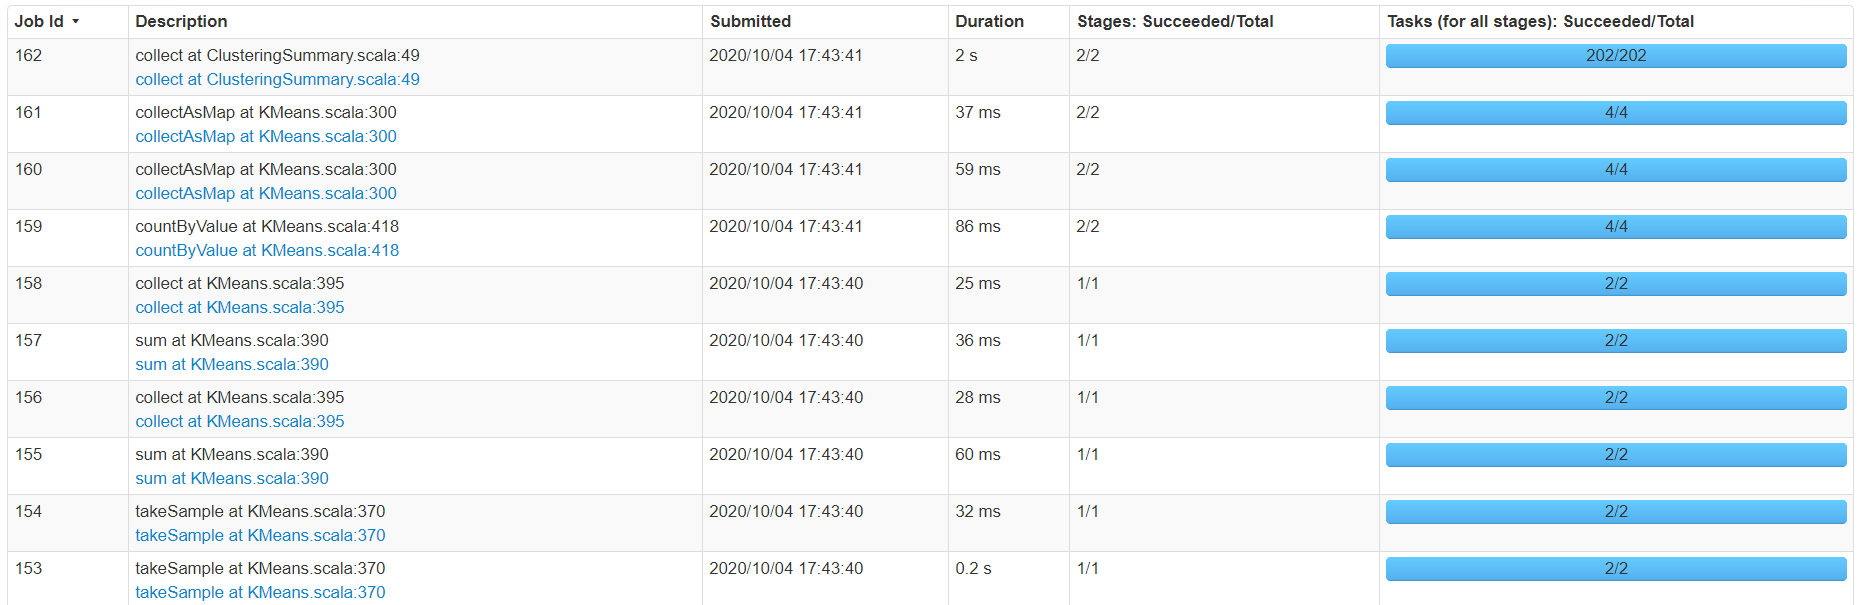





#### 3.2 Combining the KMeans algorithm from the lecture, explain what each job in Spark UI represents.

##### DESCRIPTION:

KMeans is a partitional clustering algorithm where the data objects are based on a clustering criterion.It places the data objects into clusters to maximise intra-cluster similarity.
The Kmeans algorithm partitions the given data into k clusters and each cluster has a center called centroid. As k is specified by the user, in this case k=3.
After specifying the number of clusters, the cluster centroids are found. Then each data point is observed and assigned to its closest centroid. Then for each of the cluster the mean is recalculated i.e. every cluster gets a new centroid.
All these steps are repeated until all the clusters become stable i.e. the convergence criteria is met.
As it can be seen from the Spark UI, samples from the dataset are taken and the initial centroids are guessed based on the data.
Now the data is put into the clusters according to their distance from the centroid. Then the centroids are re-calculated for the 3 clusters.
The values are then counted by value in order to get the number of occurrences of each element.
And now the values are collected as map and as it is returning Map collection only the pairs with unique keys and pairs with duplicate keys will be removed.
Now, the Clustering Summary is collected after no movement from clusters is seen and thus the process is terminated.
